In [1]:
!pip install keras-tuner

In [2]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout

# 1. CIFAR-10 데이터셋 로드
# CIFAR-10은 32x32 크기의 컬러 이미지(3채널)로 구성되며, 10개의 클래스를 가짐
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# CIFAR-10 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Training set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (50000, 32, 32, 3) (50000, 1)
Test set shape: (10000, 32, 32, 3) (10000, 1)


초기 Training 데이터 샘플 시각화


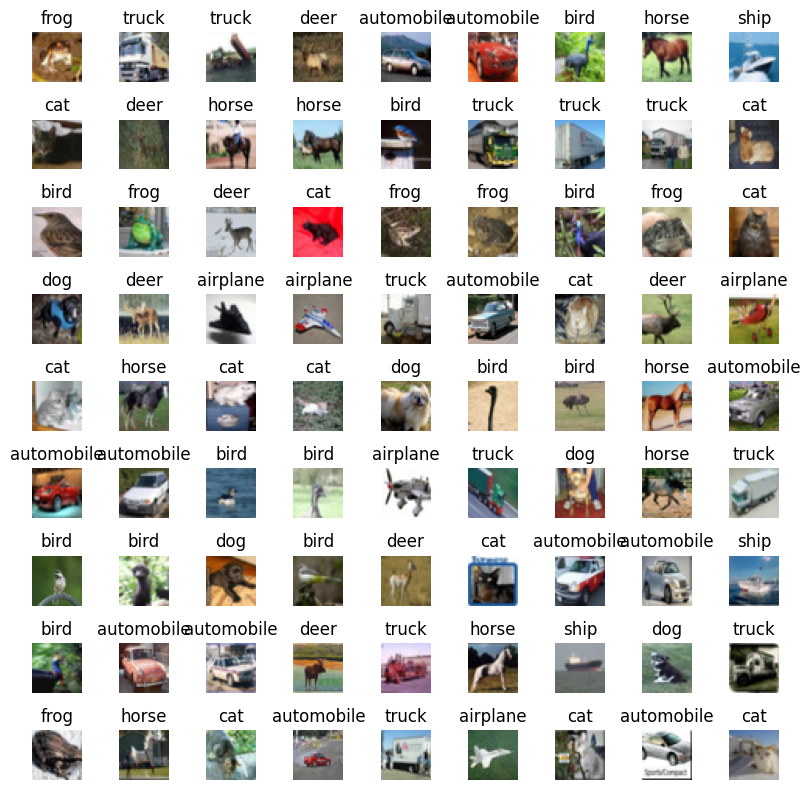

In [3]:
# 2. 데이터 시각화 함수 정의
def visualize_cifar10(images, labels, class_names, num_images=81):
    """
    주어진 images, labels를 이용하여 num_images 81개를
    9x9 그리드로 시각화하고, 각 이미지의 클래스명을 보여주는 함수.
    """
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(9, 9, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("초기 Training 데이터 샘플 시각화")
visualize_cifar10(x_train, y_train, class_names)

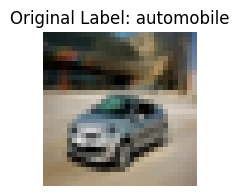

In [4]:
index_to_fix = 2428

# 수정 전 시각화
plt.figure(figsize=(2,2))
plt.imshow(x_train[index_to_fix])
plt.title(f"Original Label: {class_names[y_train[index_to_fix][0]]}")
plt.axis('off')
plt.show()

[전처리 후 데이터 샘플 시각화]


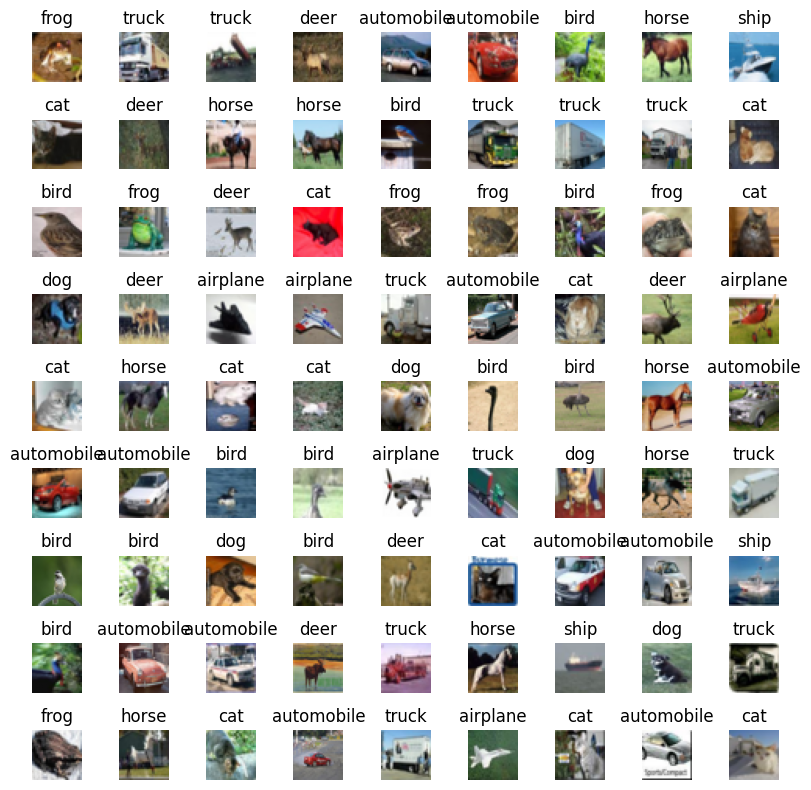

In [5]:
# 4. 데이터 전처리 (정규화)
# 모델 학습을 위해 픽셀 값을 0~255에서 0~1 범위로 스케일링
x_train = x_train / 255.0
x_test = x_test / 255.0

print("[전처리 후 데이터 샘플 시각화]")
# 정규화 후에도 육안으로는 큰 차이를 느끼기 어렵지만,
# 실제로 모델 학습에 더 안정적인 입력값을 제공.
visualize_cifar10(x_train, y_train, class_names)

In [6]:
# 5. 모델 빌드 함수 정의
# Conv2D(32) -> AveragePooling2D -> BatchNormalization
# Conv2D(64) -> AveragePooling2D -> BatchNormalization
# Flatten -> Dense(256) -> Dropout(0.5) -> Dense(10)
# 하이퍼파라미터: learning_rate만 튜닝 (1e-2, 1e-3, 1e-4)
def build_model(hp):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        AveragePooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        AveragePooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
# 6. 하이퍼파라미터 튜닝
# Hyperband를 사용해 최고 성능의 learning_rate 선택
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_results',
    project_name='cifar10_tuning_fixed_arch'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("하이퍼파라미터 튜닝")
tuner.search(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 3 Complete [00h 00m 20s]
val_accuracy: 0.5561000108718872

Best val_accuracy So Far: 0.5878000259399414
Total elapsed time: 00h 01m 06s


In [8]:
# 튜닝 후 최적 하이퍼파라미터 추출
best_hps = tuner.get_best_hyperparameters()[0]
best_lr = best_hps.get('learning_rate')
print(f"최적 하이퍼파라미터 (learning_rate): {best_lr}")

# 최적의 하이퍼파라미터로 모델 재구성
model = tuner.hypermodel.build(best_hps)

print("최적 하이퍼파라미터로 모델 학습")
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

최적 하이퍼파라미터 (learning_rate): 0.0001
최적 하이퍼파라미터로 모델 학습
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.3536 - loss: 1.9591 - val_accuracy: 0.5390 - val_loss: 1.2952
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5243 - loss: 1.3450 - val_accuracy: 0.6048 - val_loss: 1.1303
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5851 - loss: 1.1708 - val_accuracy: 0.6299 - val_loss: 1.0484
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6382 - loss: 1.0342 - val_accuracy: 0.6528 - val_loss: 0.9812
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6707 - loss: 0.9307 - val_accuracy: 0.6709 - val_loss: 0.9374
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7114 - loss: 0.8230 - val_accuracy: 0.6753 - val_loss: 0.9292
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7319 - loss: 0.7692 - val_accuracy: 0.6913 - val_loss: 0.8853
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━

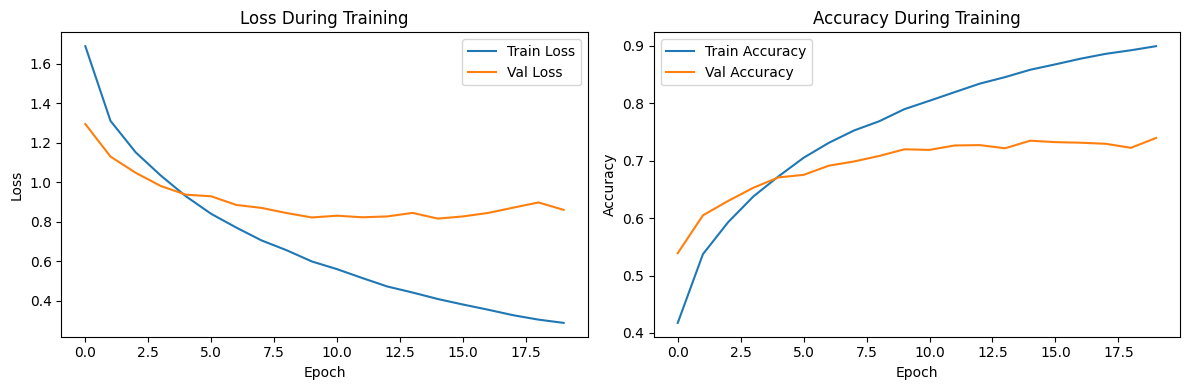

In [9]:
# 8. 학습 결과 시각화
plt.figure(figsize=(12,4))

# Training/Validation Loss 시각화
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training/Validation Accuracy 시각화
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# 학습이 끝난 모델을 추후 재사용하기 위해 저장
model.save('saved_model/cifar10_model.h5')